This project focuses on leveraging deep learning techniques to detect brain tumors from MRI images. By employing convolutional neural networks (CNNs), the model classifies images into two categories: brain tumor or healthy images. The goal is to achieve an efficient and accurate classification system that assists in medical diagnoses.

# Preprocess and partition dataset of brain MRI images.



In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: deepikakumarchd
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection


100%|██████████| 15.1M/15.1M [00:00<00:00, 58.8MB/s]


In [3]:
# loading required libraries

import tensorflow as tf
from tensorflow.keras import models , layers
import numpy as np
import matplotlib.pyplot as plt

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 23
CHANNELS = 3
EPOCHS = 30

In [5]:
# loading the images from directory

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/brain_tumor_dataset",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 253 files belonging to 2 classes.


In [6]:
class_names = dataset.class_names
class_names

['no', 'yes']

In [7]:
len(dataset)

11

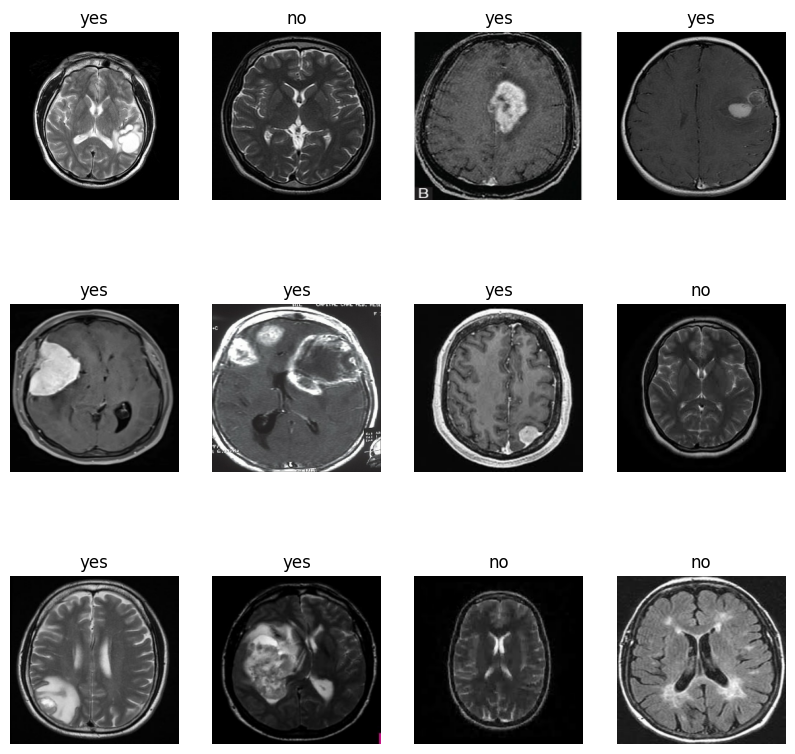

In [8]:
# visualizing the dataset

plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):  # will give 1 batch
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
def get_dataset_partitions_tf (ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    """
    Splits a tf.data.Dataset into training, validation, and test datasets.

    Args:
        ds (tf.data.Dataset): The input dataset to be split.
        train_split (float): Fraction of data for the training set (default: 0.8).
        val_split (float): Fraction of data for the validation set (default: 0.1).
        test_split (float): Fraction of data for the test set (default: 0.1).
        shuffle (bool): Whether to shuffle the dataset before splitting (default: True).
        shuffle_size (int): Buffer size for shuffling (default: 10000).

    Returns:
        tuple: (train_ds, val_ds, test_ds), the three dataset partitions.
    """

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12) # seed is for predictibility , gives you the same result everytime.

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

Dataset partitioned into training (80%), validation (10%), and test (10%) subsets.

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
# caching and prefetching

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [12]:
#preprocessing
#scaling
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [13]:
#augmentation

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# convolutional neural network (CNN)


In [14]:
# create model

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    layers.Input(shape=input_shape),
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu' ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu' ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu' ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu' ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu' ),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build()

In [15]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# compile model

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
# Model training

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.4391 - loss: 0.9493 - val_accuracy: 0.6957 - val_loss: 0.6512
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.5692 - loss: 0.7838 - val_accuracy: 0.6957 - val_loss: 0.6915
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.5807 - loss: 0.6864 - val_accuracy: 0.6957 - val_loss: 0.5948
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.5817 - loss: 0.6541 - val_accuracy: 0.6957 - val_loss: 0.6702
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.6784 - loss: 0.6267 - val_accuracy: 0.7391 - val_loss: 0.6339
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.6853 - loss: 0.5562 - val_accuracy: 0.7826 - val_loss: 0.4901
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.7102 - loss: 0.5929 - val_accuracy: 0.7826 - val_loss: 0.5770
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.7599 - loss: 0.5390 - val_accuracy: 0.8261 - val_loss: 0.4209
Epoch 9/

# Evaluating model performance and visualizing predictions.

In [21]:
scores = model.evaluate(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 785ms/step - accuracy: 0.7536 - loss: 0.5294


In [22]:
scores

[0.5068916082382202, 0.760869562625885]

In [23]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [24]:
history.history['accuracy']

[0.4836956560611725,
 0.58152174949646,
 0.5869565010070801,
 0.5869565010070801,
 0.6847826242446899,
 0.7228260636329651,
 0.7119565010070801,
 0.7663043737411499,
 0.7445651888847351,
 0.75,
 0.77173912525177,
 0.739130437374115,
 0.7445651888847351,
 0.782608687877655,
 0.79347825050354,
 0.7554348111152649,
 0.8260869383811951,
 0.760869562625885,
 0.8097826242446899,
 0.760869562625885,
 0.7554348111152649,
 0.760869562625885,
 0.79347825050354,
 0.8260869383811951,
 0.79347825050354,
 0.804347813129425,
 0.804347813129425,
 0.8260869383811951,
 0.7445651888847351,
 0.7663043737411499]

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

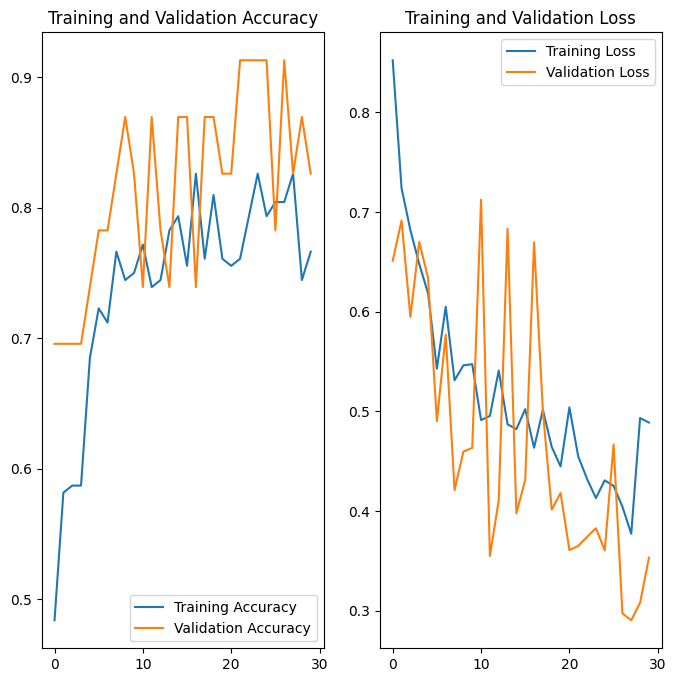

In [27]:
# plotting accuracy and loss

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
def predict(model,img):

  #   Args:
  #       model: The trained model for prediction.
  #       img: A single image (not batched).

  #   Returns:
  #       Returns the predicted class and confidence level.

    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)  # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


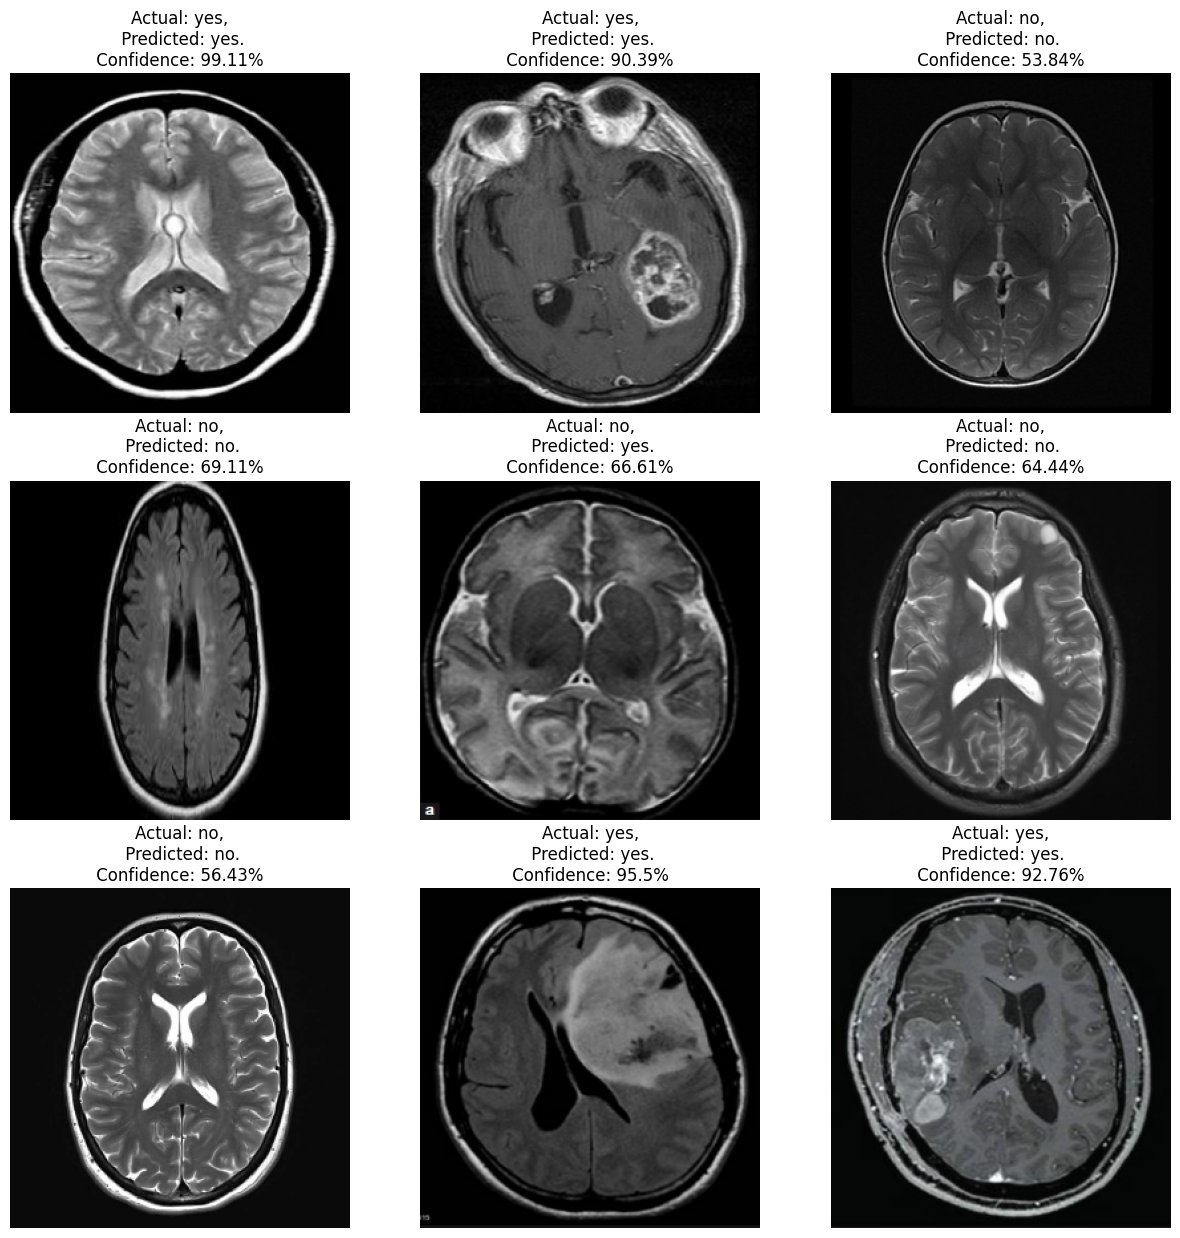

In [29]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)

        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}% ")

        plt.axis("off")